In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import gdown
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

데이터 읽기

In [4]:
dataset = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset", label_mode=None, image_size=(120, 160), batch_size=64
)
dataset = dataset.map(lambda x: x / 255.0)

Found 1 files belonging to 1 classes.


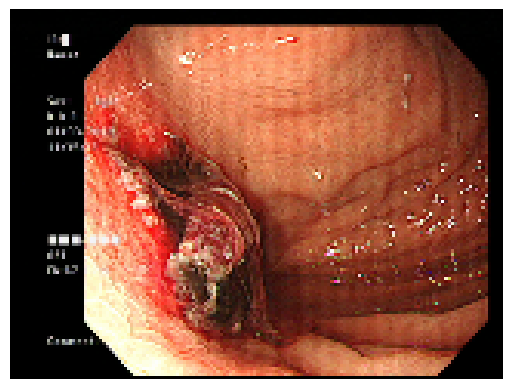

In [5]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [6]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(120, 160, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 80, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 80, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 40, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 40, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 20, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 15, 20, 128)       0         
                                                                 
 flatten (Flatten)           (None, 38400)           

In [9]:
latent_dim = 32

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(15 * 20 * 32),
        layers.Reshape((15, 20, 32)),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 9600)              316800    
                                                                 
 reshape_1 (Reshape)         (None, 15, 20, 32)        0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 30, 40, 32)        16416     
 Transpose)                                                      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 30, 40, 32)        0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 60, 80, 64)        32832     
 Transpose)                                                      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 60, 80, 64)        0 

In [10]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=32):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if epoch == epochs - 1:
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save("project2/generated_img_%03d_%d.png" % (epochs, i))

In [12]:
os.makedirs("project2")

In [13]:
epochs = 1

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=100, latent_dim=latent_dim)]
)

1/1 [==============================] - 16s 16s/step - d_loss: 0.7143 - g_loss: 0.8486


In [4]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import numpy as np

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    outputs = layers.Dense(num_classes, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2
import numpy as np
import csv

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

import keras.backend as K

import os

import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data=[]
data_label=[]
image_width=300
image_height=300
test2=10

def search(dirname):
    filenames = os.listdir(dirname)
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        aa=full_filename.split('/')
        aaa=aa[5].split('.')
        try:
            if aaa[1] == "png":
                image=cv2.imread(full_filename)
                resize_img = cv2.resize(image, (image_width, image_height))
                resize_img= resize_img/255.0
                data.append(resize_img.reshape(-1))
            if aaa[1] == "txt":
                f = open(full_filename, 'r')
                line = f.readline()
                line= line.strip('\n')
                line= float(line)
                data_label.append(line)
                f.close()
        except:
            pass

search('/content/drive/MyDrive/data_annotate2')
print('data number', len(data))
print('data label number',len(data_label))
#normalization
max_value=np.max(data_label)
data_label = data_label /max_value
np.save('./preprocess_data2',np.array(data))
np.save('./preprocess_data_label2',np.array(data_label))
data=np.load('./preprocess_data2.npy')
y_train=np.load('./preprocess_data_label2.npy')
x_train = data.reshape(len(data),image_width,image_height,3)
print(x_train.shape)
print(y_train.shape)
input_shape = (image_width,image_height,3)
#input_shape = (3,image_width*image_height)

n_classes=1
num_classes=1
epochs=1

# 모델 학습 부분
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

opt2 = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
opt2 = tf.keras.mixed_precision.LossScaleOptimizer(opt2)

model.compile(optimizer=opt2, loss=tf.keras.losses.MeanAbsolutePercentageError(),
              metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.CosineSimilarity(),
                       tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.LogCoshError()])
#model.summary()

path_checkpoint = "./wsi_area_prediction_transform_enc_experiment_final.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks = [callbacks,modelckpt_callback]
)

test_image=np.expand_dims(x_train[0],axis=0)
preds = model.predict(test_image)
print('GT',y_train[0]*max_value)
print("Prediction",preds[0][0]*max_value)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


data number 2
data label number 2
(2, 300, 300, 3)
(2,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 


1/1 [==============================] - 0s 169ms/step
GT 33.0
Prediction 35.0


In [ ]:
# -*- coding: utf-8 -*-
'''
문제 5 : utf-8 관련 내용을 빈칸 5에 채우세요 (5점)
'''


In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [8]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
'''
문제 6 : 아래 빈칸을 채우세요 (10점)
'''
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train   )
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")



x_train shape: [[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
 

In [9]:
'''
문제 7 : 아래 빈칸을 채우세요 (10점)
'''
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)             

In [11]:

batch_size = 128
epochs = 1

'''
문제 8 : 모델 설정 하는 부분입니다. 빈칸8.1(5점), 빈칸8.2(5점), 빈칸8.3(5점), 빈칸8.4(5점) 을 채우세요 (20점)
'''
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
'''
문제 9 : 모델 학습 하는 부분입니다. 아래 빈칸을 채우세요 (20점)
'''
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)




422/422 [==============================] - 4s 6ms/step - loss: 0.3512 - accuracy: 0.8939 - val_loss: 0.0808 - val_accuracy: 0.9790


In [12]:
'''
문제 10 : 모델 테스트 하는 부분입니다. 빈칸 10.1, 빈칸 10.2, 빈칸 10.3, 빈칸 10.4, 빈칸 10.5을 채우세요 (25점)
'''
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08434141427278519
Test accuracy: 0.9732999801635742
